In [ ]:
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import ast, re
from glob import glob
from time import sleep
from bs4 import BeautifulSoup
import collections
f = ''
import warnings
warnings.filterwarnings('ignore')

In [ ]:
merged_df = pd.DataFrame()
for i in ['uk', 'eu', 'jp']:
  df = pd.read_csv(f+i.upper()+'/adverse_events.csv')
  if 'ingredient_rxnorm' in df.columns:
    df.rename(columns={'ingredient_rxnorm': 'ingredient_codes'}, inplace=True)
  df = df.drop('ingredient_codes', axis=1).join(df['ingredient_codes'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('ingredient_codes'))
  df['source'] = i
  df = df[['ingredient_codes', 'pt_meddra_id', 'source']].drop_duplicates()
  df = df[~df['pt_meddra_id'].isna()] 
  merged_df = pd.concat([merged_df, df])

In [ ]:
us = 'OnSIDES/adverse_reactions.csv.gz'
us_df = pd.read_csv(us)[['ingredients_rxcuis', 'pt_meddra_id']].drop_duplicates().rename(columns={'ingredients_rxcuis': 'ingredient_codes'})
us_df = us_df.drop('ingredient_codes', axis=1).join(us_df['ingredient_codes'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('ingredient_codes'))
merged_df = pd.concat([merged_df, us_df]).drop_duplicates()
merged_df['ingredient_codes'] = merged_df.ingredient_codes.astype(str)
merged_df.head(2)

ingredient_codes  pt_meddra_id source
0              508    10020751.0     uk
0            22906    10020751.0     uk

### generate figures

In [ ]:
meddra_df = pd.read_csv(f+'meddra_formatted.csv')
rxnorm_atc_df = pd.read_csv(f+'rxnorm_atc_formatted.csv')

In [ ]:
merged_df = pd.DataFrame()
for i in ['uk', 'eu', 'jp']:
  df = pd.read_csv(f+i.upper()+'/adverse_events.csv')
  if 'ingredient_rxnorm' in df.columns:
    df.rename(columns={'ingredient_rxnorm': 'ingredient_codes'}, inplace=True)
  df = df.drop('ingredient_codes', axis=1).join(df['ingredient_codes'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('ingredient_codes'))
  df['source'] = i
  df = df[['ingredient_codes', 'pt_meddra_id', 'source']].drop_duplicates()
  df = df[~df['pt_meddra_id'].isna()]  # Filter out rows where 'pt_meddra_id' is NA
  merged_df = pd.concat([merged_df, df])
us = 'OnSIDES/adverse_reactions.csv.gz'
us_df = pd.read_csv(us)[['ingredients_rxcuis', 'pt_meddra_id']].drop_duplicates().rename(columns={'ingredients_rxcuis': 'ingredient_codes'})
us_df = us_df.drop('ingredient_codes', axis=1).join(us_df['ingredient_codes'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True).rename('ingredient_codes'))
us_df['source'] = 'us'
merged_df = pd.concat([merged_df, us_df]).drop_duplicates()
merged_df['ingredient_codes'] = merged_df.ingredient_codes.astype(str)
merged_df.head(2)

ingredient_codes  pt_meddra_id source
0              508    10020751.0     uk
0            22906    10020751.0     uk

In [ ]:
all_df = merged_df.merge(meddra_df, on='pt_meddra_id', how='left')
all_df['ingredient_codes'] = all_df.ingredient_codes.astype(str)
rxnorm_atc_df['ingredient_codes'] = rxnorm_atc_df.ingredient_codes.astype(str)
all_df = all_df.merge(rxnorm_atc_df, on='ingredient_codes', how='left')
all_df['atc_level1'] = all_df['atc_code'].apply(lambda x: x[0] if str(x) != 'nan' else None)
all_df = all_df[(all_df.soc.notna())&(all_df.atc_level1.notna())]
all_df.head(1)

ingredient_codes  pt_meddra_id source  concept_id  concept_code  \
0              508    10020751.0     uk    36009711      10020751   

       concept_name                      soc atc_code atc_level1  
0  Hypersensitivity  Immune system disorders  S03AA30          S

In [ ]:
extf = 'rxnorm_atc_athena/'
atc = pd.read_csv(extf+'CONCEPT.csv', delimiter = '\t')[['concept_code', 'concept_id', 'concept_name', 'vocabulary_id', 'concept_class_id']]
atc = atc[atc.vocabulary_id == 'ATC']
atc_dict = dict(zip(atc.concept_code, atc.concept_name))
all_df['atc_name'] = all_df.atc_code.map(atc_dict)

In [ ]:
#EU, Japan, US, UK
palette ={"US":'#FEFE62', "EU":'#1A85FF', "Japan":'#D41159', 'UK':'#40B0A6'}

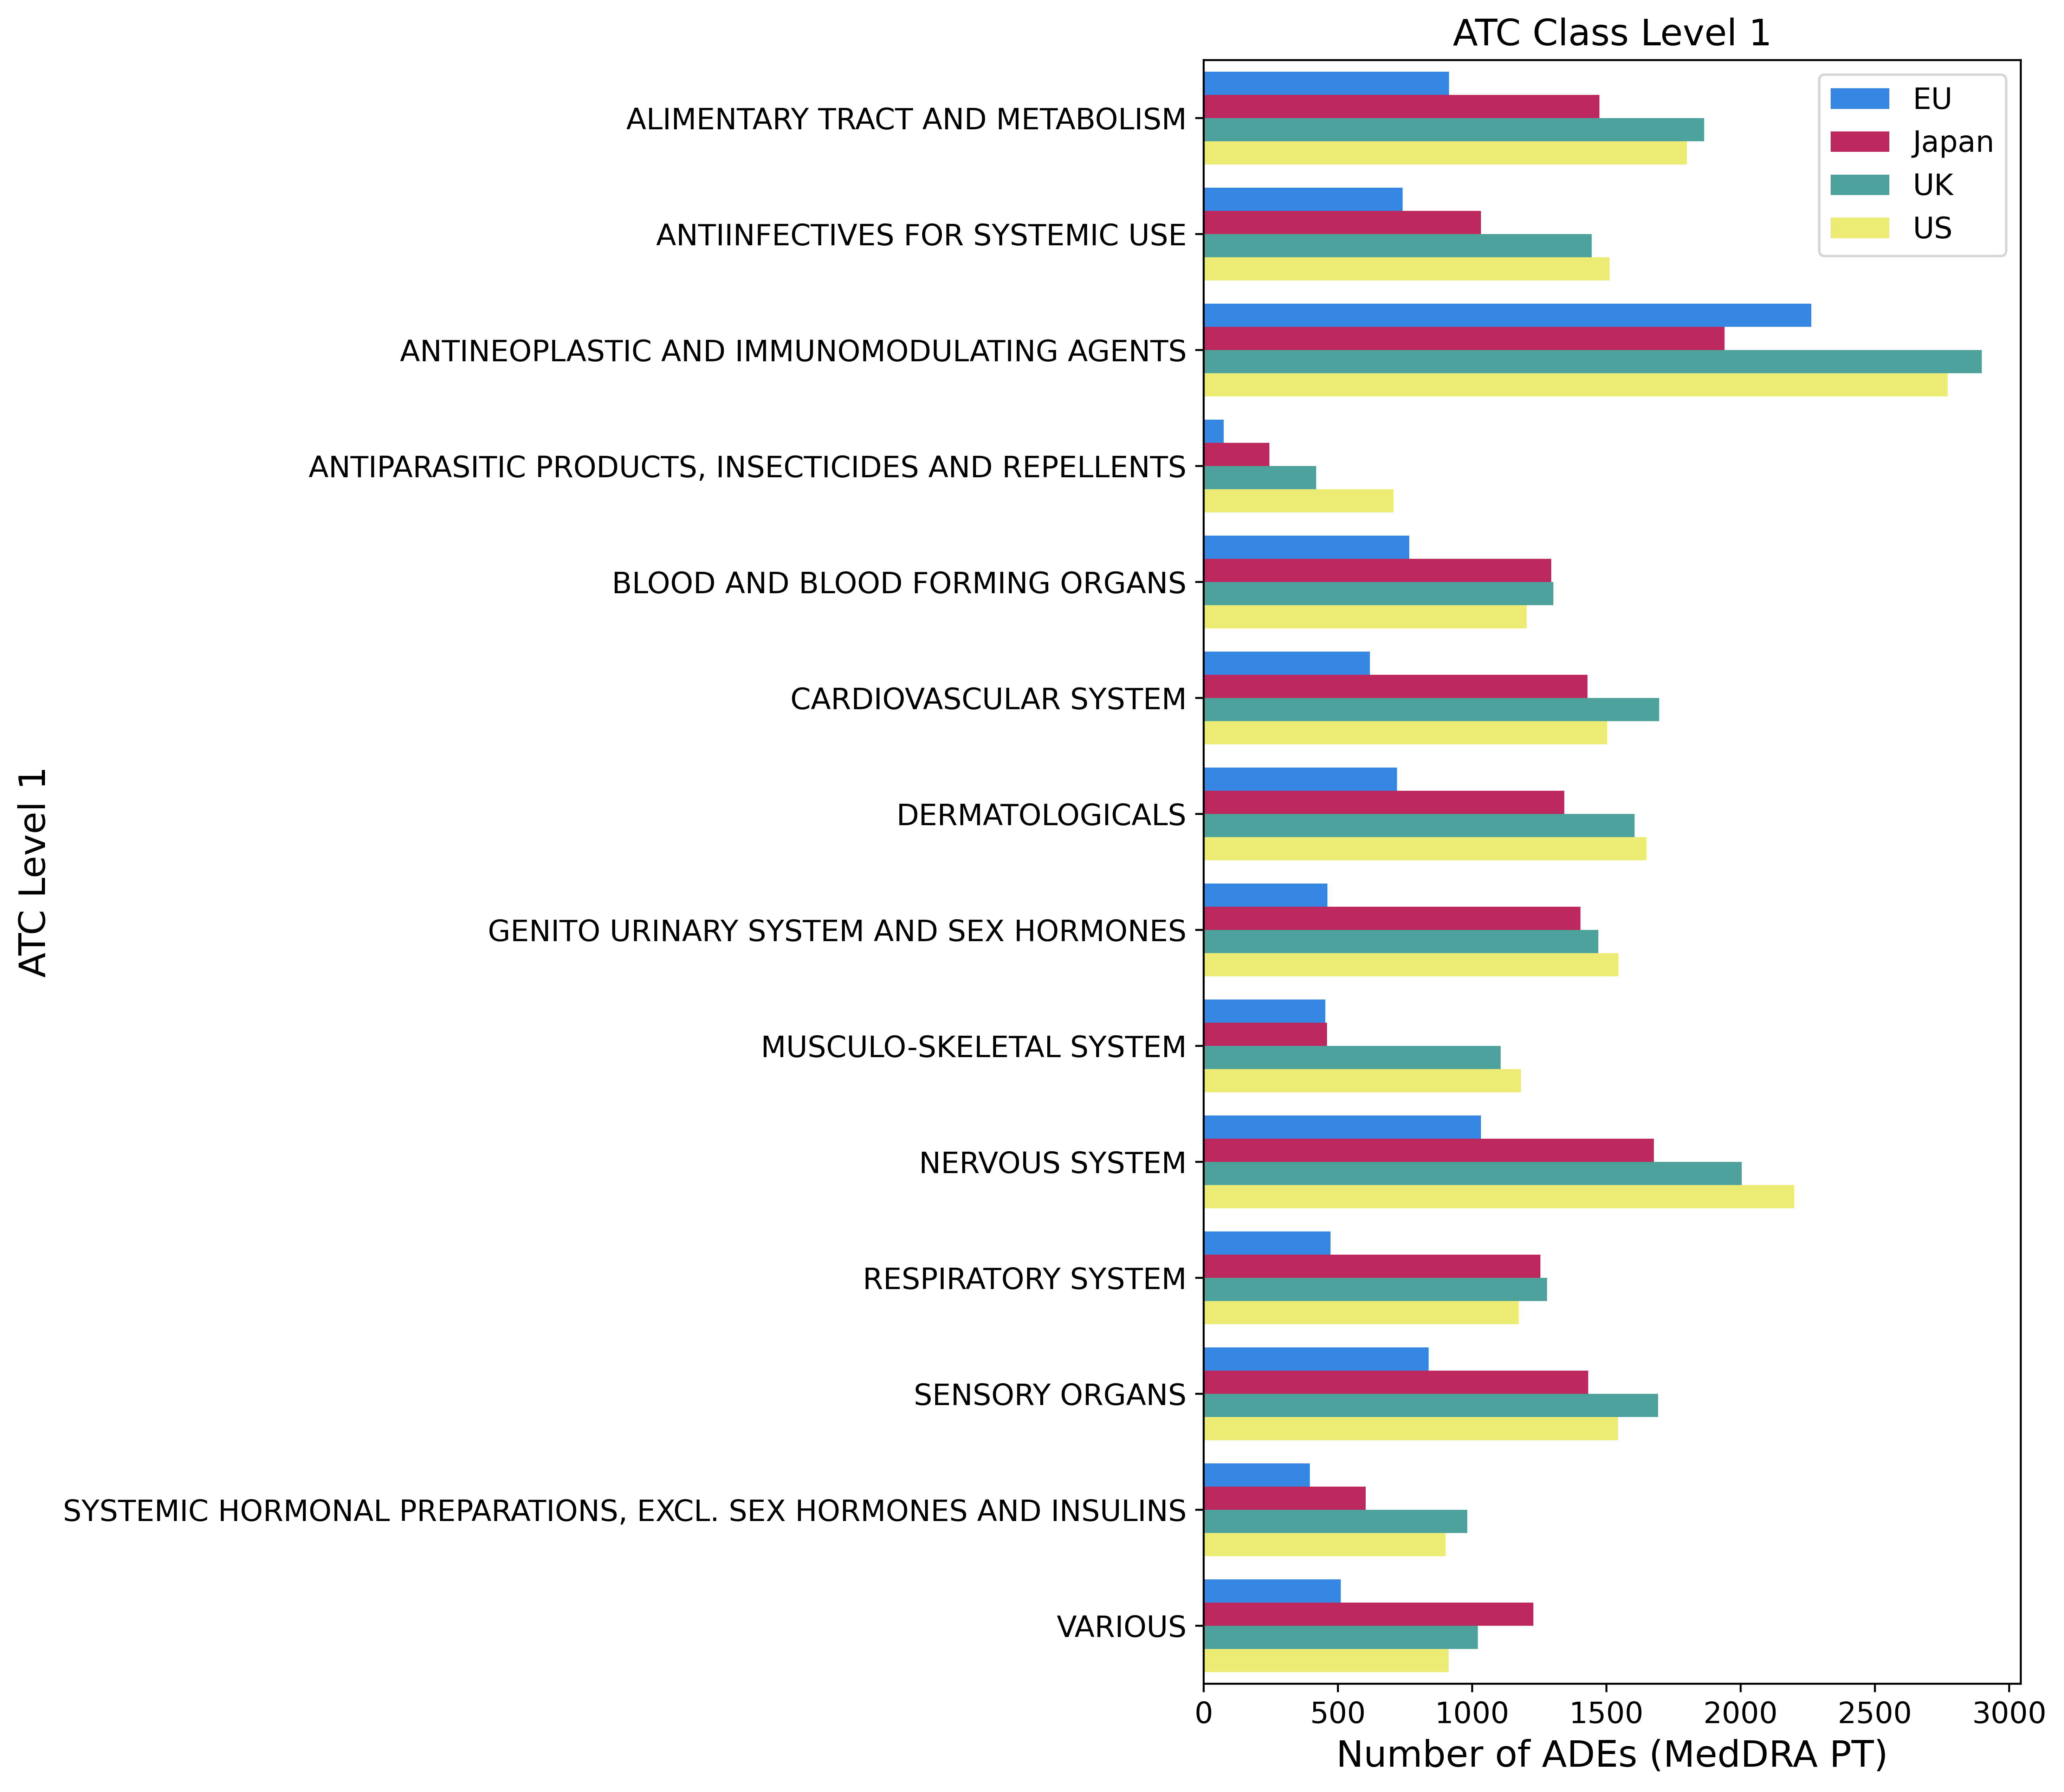

In [ ]:
plt.figure(figsize=(6,12), dpi = 500)
figa = all_df.groupby(['atc_level1', 'source'])['pt_meddra_id'].apply(set).reset_index()
figa['n_adrs'] = figa.pt_meddra_id.apply(len)
figa_source = {'eu':'EU', 'jp':'Japan', 'uk':'UK', 'us':'US'}
figa['source'] = figa.source.map(figa_source)
figa['atc_level1'] = figa.atc_level1.map(atc_dict)
figa = figa.sort_values('atc_level1')
sns.barplot(data=figa, y='atc_level1', x='n_adrs', hue='source', dodge=True, palette = palette)
plt.title('ATC Class Level 1', fontsize=15)
plt.ylabel('ATC Level 1', fontsize=15)
plt.xlabel('Number of ADEs (MedDRA PT)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

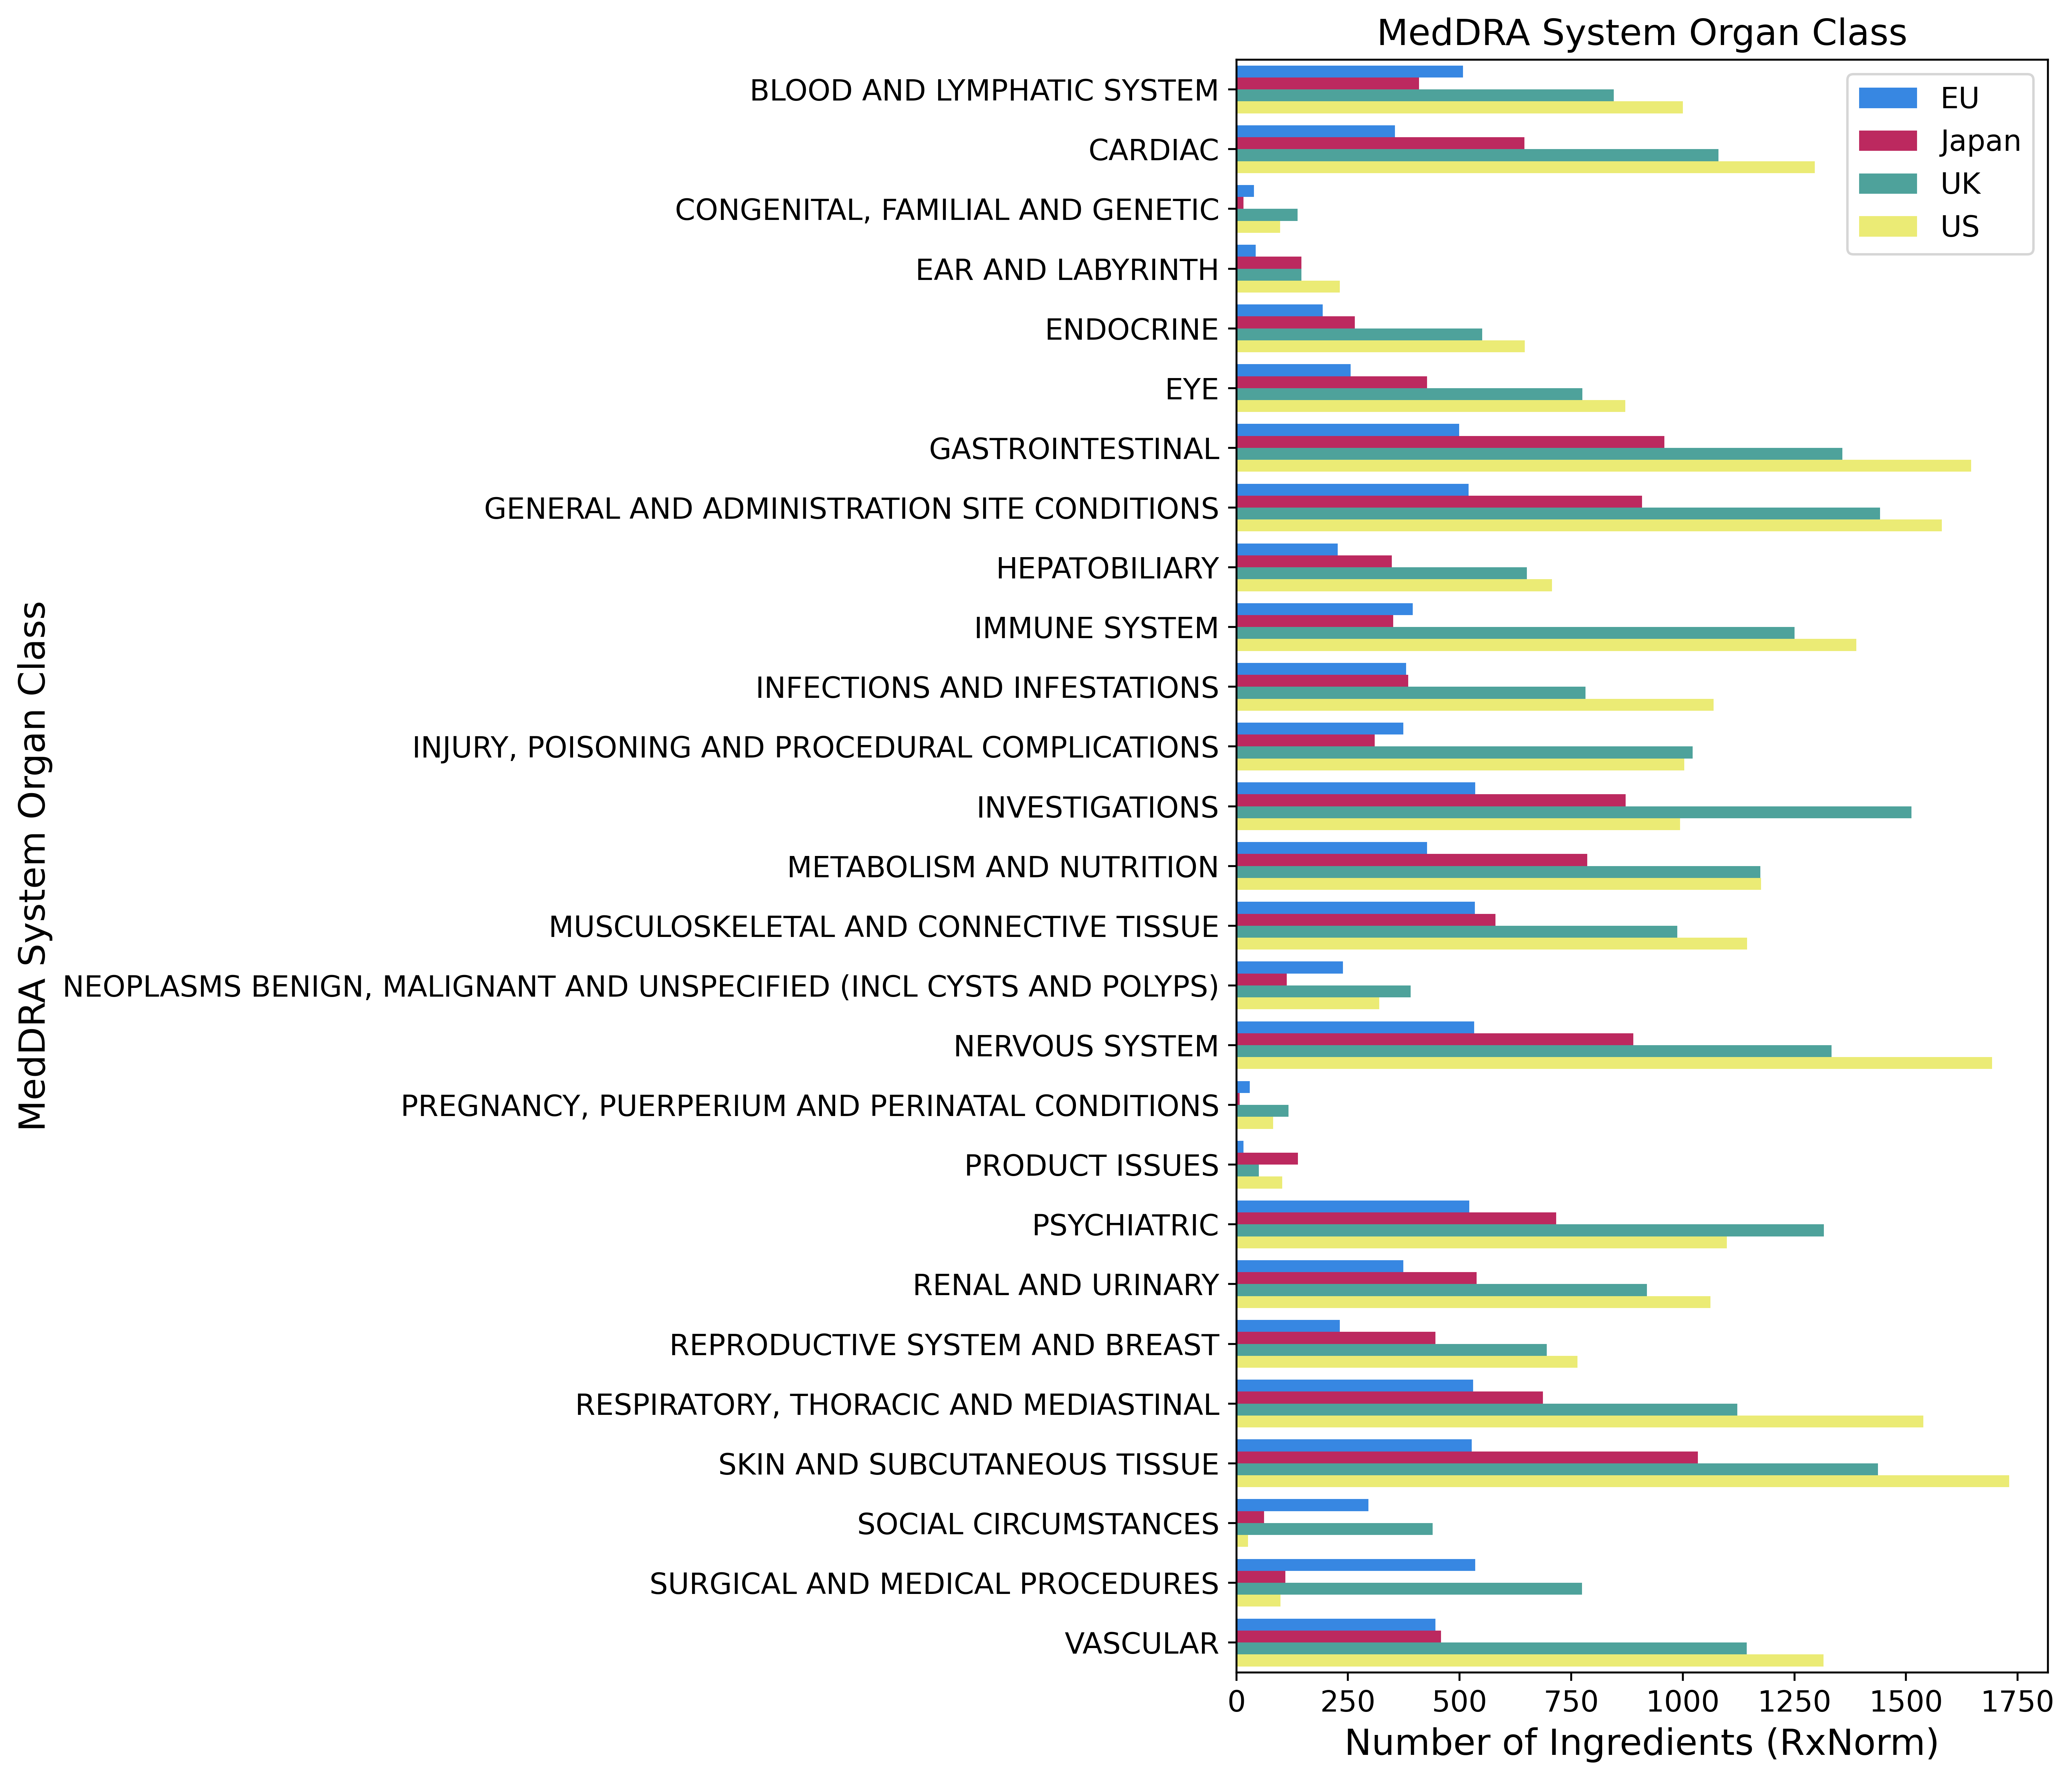

In [ ]:
plt.figure(figsize=(6,12), dpi = 500)
figb = all_df.groupby(['soc', 'source'])['ingredient_codes'].apply(set).reset_index()
figb['n_adrs'] = figb.ingredient_codes.apply(len)
figb_source = {'eu':'EU', 'jp':'Japan', 'uk':'UK', 'us':'US'}
figb['source'] = figb.source.map(figb_source)
figb['soc'] = figb.soc.apply(lambda x: x.replace(' disorders', '').upper())
figb = figb.sort_values('soc')
sns.barplot(data=figb, y='soc', x='n_adrs', hue='source', dodge=True, palette = palette)
plt.title('MedDRA System Organ Class', fontsize=15)
plt.ylabel('MedDRA System Organ Class', fontsize=15)
plt.xlabel('Number of Ingredients (RxNorm)', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12)
plt.show()

In [ ]:
heatmap_df = all_df.copy()
heatmap_df['ingredient_adr_combo'] = heatmap_df['atc_level1'].astype(str) + "_" + heatmap_df['pt_meddra_id'].astype(str)
heatmap_df = heatmap_df[['source', 'soc', 'atc_level1', 'ingredient_adr_combo']].drop_duplicates()
heatmap_df = heatmap_df.assign(ingredient_adr_combo=heatmap_df['ingredient_adr_combo'].apply(lambda x: list(combinations(x.split('_'), 2))))
heatmap_df = heatmap_df.explode('ingredient_adr_combo').pivot_table(index=['soc', 'atc_level1'], columns='source', values='ingredient_adr_combo', aggfunc=lambda x: x)
heatmap_df = heatmap_df.reset_index()
for i in ['eu', 'uk', 'jp']:
  heatmap_df['{}_intersection'.format(i)] = heatmap_df.apply(lambda row: len(set(row['us']) & set(row[i])) if str(row['us']) != 'nan' and str(row[i]) != 'nan' else 0, axis=1)
  heatmap_df['{}_union'.format(i)] = heatmap_df.apply(lambda row: len(set(row['us']) | set(row[i])) if str(row['us']) != 'nan' and str(row[i]) != 'nan' else 0, axis=1)
  heatmap_df['{}_jaccard'.format(i)] = heatmap_df['{}_intersection'.format(i)] / heatmap_df['{}_union'.format(i)]
heatmap_df = heatmap_df.fillna(0)
heatmap_df = heatmap_df[['soc', 'atc_level1', 'eu_jaccard', 'uk_jaccard', 'jp_jaccard']]
heatmap_df['atc_level1'] = heatmap_df.atc_level1.map(atc_dict)
heatmap_df['soc'] = heatmap_df.soc.apply(lambda x: x.replace(' disorders', '').upper())
fig, axs = plt.subplots(3, 1, figsize=(12, 18), sharex=True, dpi = 500)
figc_source = {'eu':'EU', 'jp':'Japan', 'uk':'UK', 'us':'US'}
for idx, i in enumerate(['eu', 'jp', 'uk']):
  heatmap = sns.heatmap(heatmap_df.pivot(index='soc', columns='atc_level1', values='{}_jaccard'.format(i)),
                      cbar_kws={'label': 'Jaccard Index'}, ax=axs[idx], fmt=".2f", cmap = 'bwr', vmin=0, vmax=1, center = 0.5)
  axs[idx].set_title(figc_source[i], fontsize=14, pad=10)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.show()

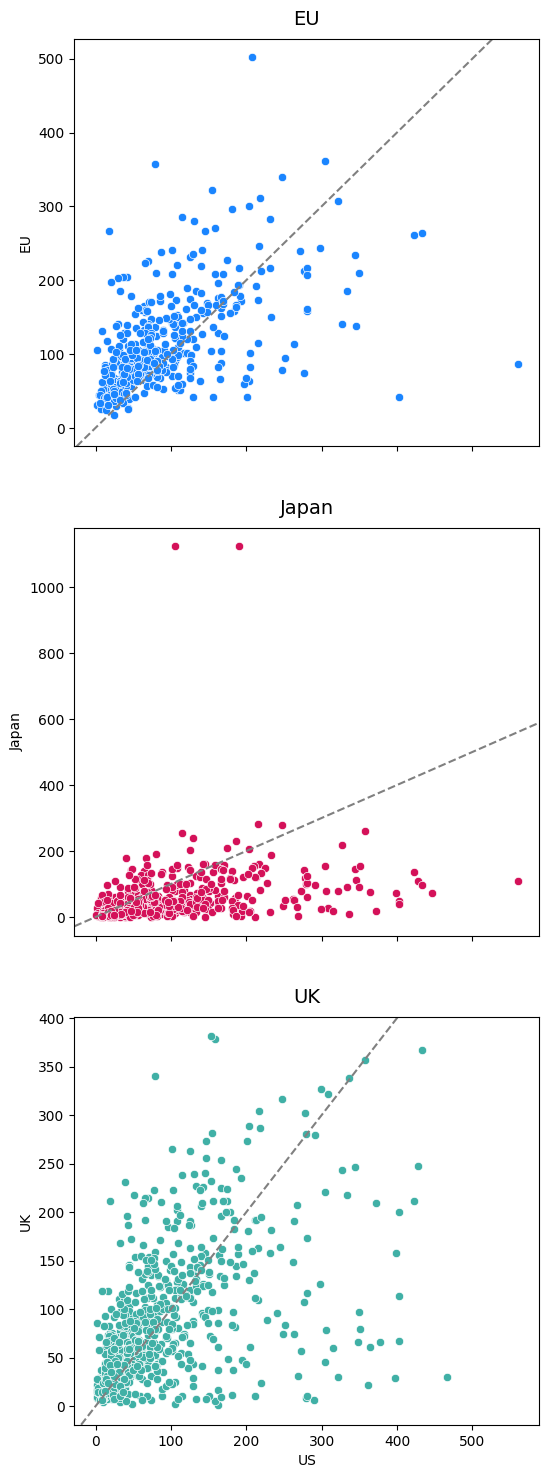

In [ ]:
figd = all_df.groupby(['ingredient_codes', 'source'])['pt_meddra_id'].apply(set).reset_index()
figd['num_ades'] = figd.pt_meddra_id.apply(len)
figd_source = {'eu':'EU', 'jp':'Japan', 'uk':'UK', 'us':'US'}
figd['source'] = figd.source.map(figd_source)
figd = figd.pivot_table(index=['ingredient_codes'], columns='source', values='num_ades', aggfunc=lambda x: x)
figd = figd[figd.US.notna()]
fig, axs = plt.subplots(3, 1, figsize=(6,18), sharex=True)
for idx, i in enumerate(['EU', 'Japan', 'UK']):
  scatter = sns.scatterplot(data=figd, x='US', y=i, ax=axs[idx], c=palette[i])
  axs[idx].axline((0, 0), slope=1, linestyle = '--', color = 'grey')
  axs[idx].set_title(i, fontsize=14, pad=10)
plt.show()